# Imports and Configurations

In [92]:
%pip install googletrans
%pip install nltk
%pip install autocorrect
%pip install squarify

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [93]:
import pandas as pd
import numpy as np

import re
import nltk
from num2words import num2words

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from autocorrect import Speller
from sklearn.feature_extraction.text import CountVectorizer

from googletrans import Translator
import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import squarify
# To perform KMeans clustering 
from sklearn.cluster import KMeans
# t-SNE with scikit-learn
from sklearn.manifold import TSNE

# dataset visibility
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [94]:
nltk.download('rslp')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package rslp to /Users/aleksandr/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aleksandr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aleksandr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Functions

In [95]:
def remove_stop_words(text):
    for word in text:
        if word in stopwords.words('english'):
            text.remove(word)
    return text

ps = PorterStemmer()
spell = Speller('en')

def spell_and_stem_words(text):
    for i in range(len(text)):
        text[i] = ps.stem(spell(text[i]))
    return text

# Joining dataset

In [96]:
#final dataframe
df = pd.DataFrame()

In [97]:
# read all datasets

# orders dataset
orders = pd.read_csv('data/olist_orders_dataset.csv')

# order items dataset
items = pd.read_csv('data/olist_order_items_dataset.csv')

# sellers dataset
sellers = pd.read_csv('data/olist_sellers_dataset.csv')

# sellers dataset
customers = pd.read_csv('data/olist_customers_dataset.csv')

# reviews dataset
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')

# products dataset
products = pd.read_csv('data/olist_products_dataset.csv')

# sellers dataset
payments = pd.read_csv('data/olist_order_payments_dataset.csv')

# categories dataset
categories = pd.read_csv('data/product_category_name_translation.csv')

In [98]:
df = orders

df = df.merge(customers, on='customer_id', how='left')
df = df.merge(payments, on='order_id', how='left')
df = df.merge(reviews, on='order_id', how='left')

df = df.merge(items, on='order_id', how='left')
df = df.merge(sellers, on='seller_id', how='left')
df = df.merge(products, on='product_id', how='left')
df = df.merge(categories, on='product_category_name', how='left')

#df.head()

In [99]:
df.to_csv('data/merged_dataset.csv')

# EDA

## Customers

In [100]:
customers.info()
customers.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [101]:
cust = customers["customer_unique_id"].nunique()
print(cust, "unique customers")

96096 unique customers


There are 4119 unique cities in the dataset. The Top 10 cities based on customers_id are:
customer_city
sao paulo                15540
rio de janeiro            6882
belo horizonte            2773
brasilia                  2131
curitiba                  1521
campinas                  1444
porto alegre              1379
salvador                  1245
guarulhos                 1189
sao bernardo do campo      938
Name: customer_id, dtype: int64

Top 10 cities covers 35.2 percent of all the orders.


<AxesSubplot:xlabel='customer_city'>

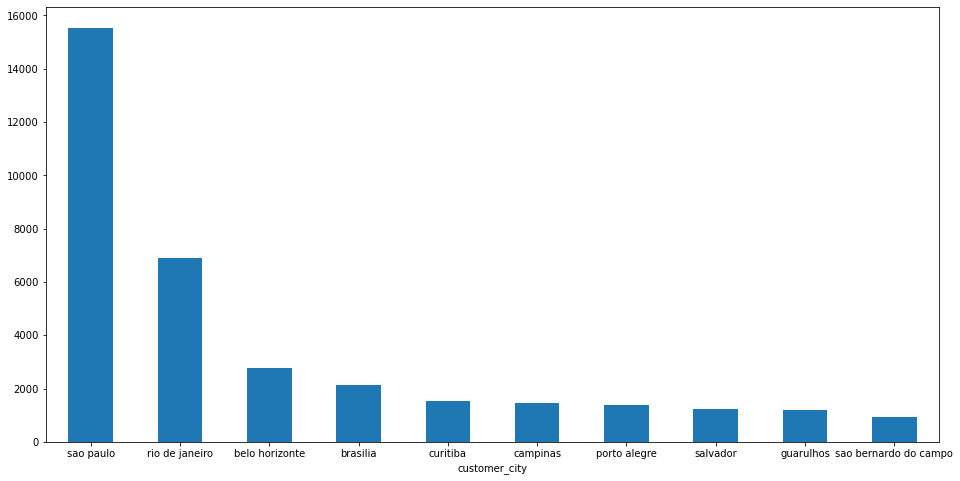

In [102]:
cities = customers["customer_city"].nunique()
c1 = customers.groupby('customer_city')['customer_id'].nunique().sort_values(ascending=False)
print("There are",cities,"unique cities in the dataset. The Top 10 cities based on customers_id are:")
c2 = c1.head(10)
print(c2)
print("\nTop 10 cities covers", round(c2.sum()/customers.shape[0]*100,1),"percent of all the orders.")
plt.figure(figsize=(16,8))
c2.plot(kind="bar",rot=0)

There are 4119 unique states in the dataset. The Top 5 states are:
customer_state
SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
Name: customer_id, dtype: int64

Top 10 states covers 77.2 percent of all the orders.


<AxesSubplot:xlabel='customer_state'>

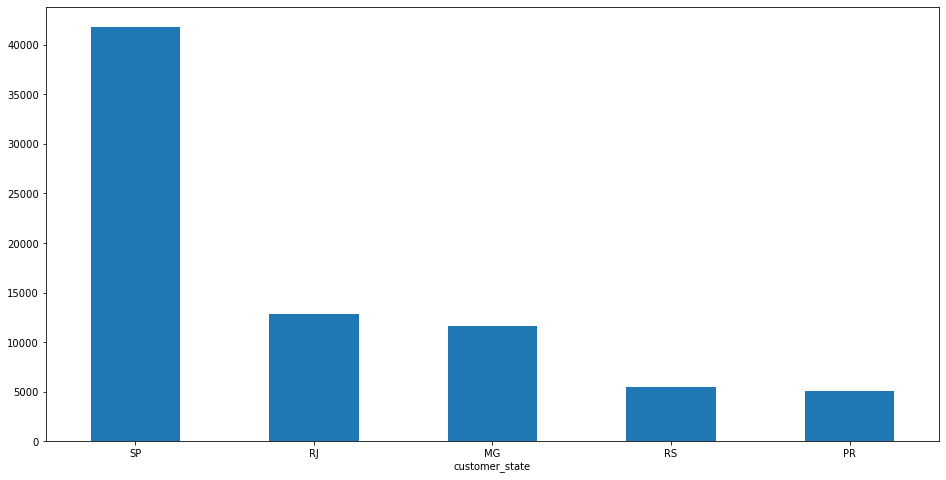

In [103]:
state = customers["customer_state"].nunique()
c1 = customers.groupby('customer_state')['customer_id'].nunique().sort_values(ascending=False)
print("There are",cities,"unique states in the dataset. The Top 5 states are:")
c2 = c1.head(5)
print(c2)
print("\nTop 10 states covers", round(c2.sum()/customers.shape[0]*100,1),"percent of all the orders.")
plt.figure(figsize=(16,8))
c2.plot(kind="bar",rot=0)

## Orders

In [104]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [105]:
orders.info()
customers.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [106]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [107]:
orders_mod = orders.copy()
orders_mod["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"], format='%Y-%m-%d %H:%M:%S')
orders_mod["order_delivered_carrier_date"] = pd.to_datetime(orders["order_delivered_carrier_date"], format='%Y-%m-%d %H:%M:%S')
orders_mod["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"], format='%Y-%m-%d %H:%M:%S')
orders_mod["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"], format='%Y-%m-%d %H:%M:%S')
orders_mod.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [108]:
orders_mod.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


<AxesSubplot:xlabel='order_purchase_timestamp'>

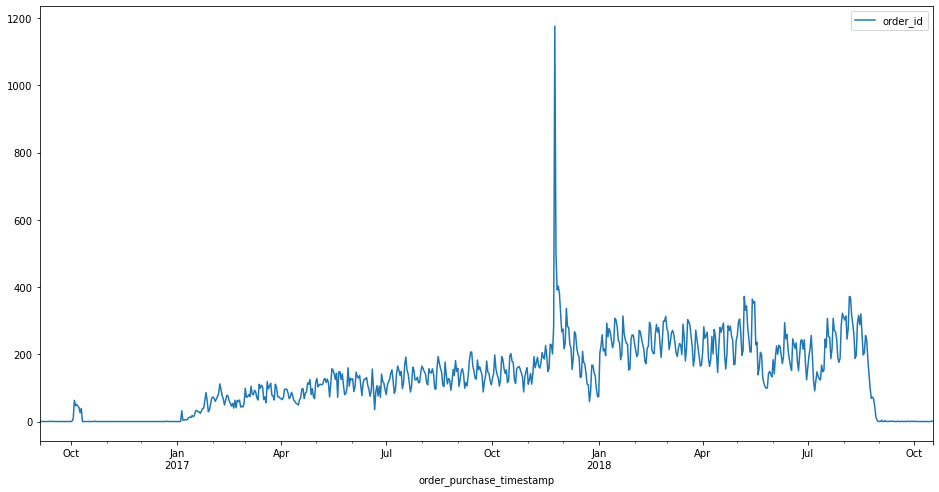

In [109]:
##Viz on when purchases are made during period in dataset.
counts = orders_mod.set_index("order_purchase_timestamp").groupby(pd.Grouper(freq='D')).count()
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
counts.plot(y = "order_id", use_index=True, ax=ax)

There are 8 unique order_status in the dataset.
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: customer_id, dtype: int64

Delivered status covers 97.0 percent of all the orders.


<AxesSubplot:xlabel='order_status'>

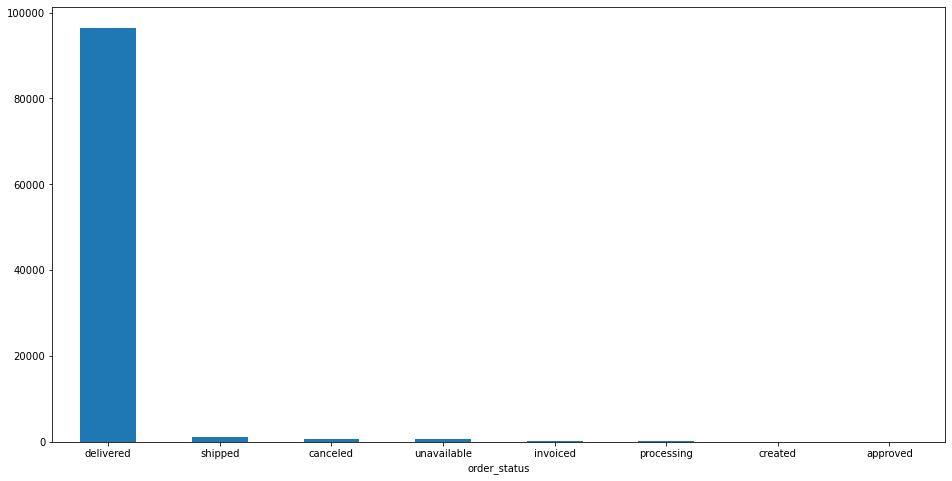

In [110]:
##Identifies orderstatus distribution
orderstatus = orders["order_status"].nunique()
o1 = orders.groupby('order_status')['customer_id'].nunique().sort_values(ascending=False)
print("There are",orderstatus,"unique order_status in the dataset.")
o2 = o1.head(8)
print(o2)
o3 = o1.head(1)
print("\nDelivered status covers", round(o3.sum()/orders.shape[0]*100,1),"percent of all the orders.")
plt.figure(figsize=(16,8))
o2.plot(kind="bar",rot=0)

## Order Reviews

In [111]:
reviews.info()
reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [112]:
reviews.isnull().values.any()

True

In [113]:
# Determine how many missing data instances
reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [114]:
# Address missing data - we can see that there is a review score but not necessarily a comment or a title. Should we make it "none?"

reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

## Items

In [115]:
items.info()
items.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

There are                                 order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2       c777355d18b72b67abbeef9df44fd0fd  5b510

<AxesSubplot:xlabel='seller_id'>

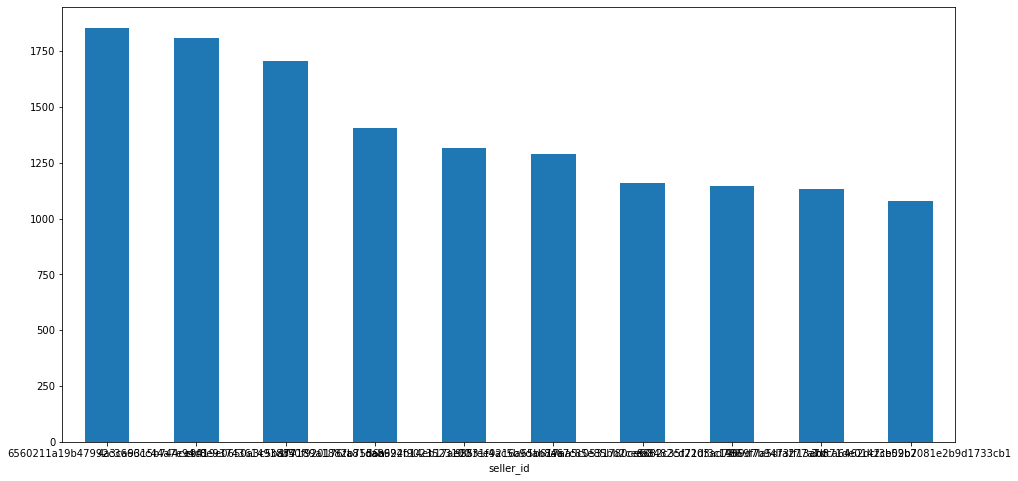

In [116]:
sellerinfo = items["seller_id"].nunique()
o1 = items.groupby('seller_id')['order_id'].nunique().sort_values(ascending=False)
print("There are",items,"unique items in the dataset.")
o2 = o1.head(10)
print(o2)

print("\nTop 10 items covers", round(o2.sum()/orders.shape[0]*100,1),"percent of all the orders.")
plt.figure(figsize=(16,8))
o2.plot(kind="bar",rot=0)

## Sellers

In [117]:
sellers.info()
sellers.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

There are 3095 unique sellers in the dataset.
seller_city
sao paulo         694
curitiba          127
rio de janeiro     96
belo horizonte     68
ribeirao preto     52
guarulhos          50
ibitinga           49
santo andre        45
Name: seller_id, dtype: int64

Top Seller by city covers 1.2 percent of all the sellers.


<AxesSubplot:xlabel='seller_city'>

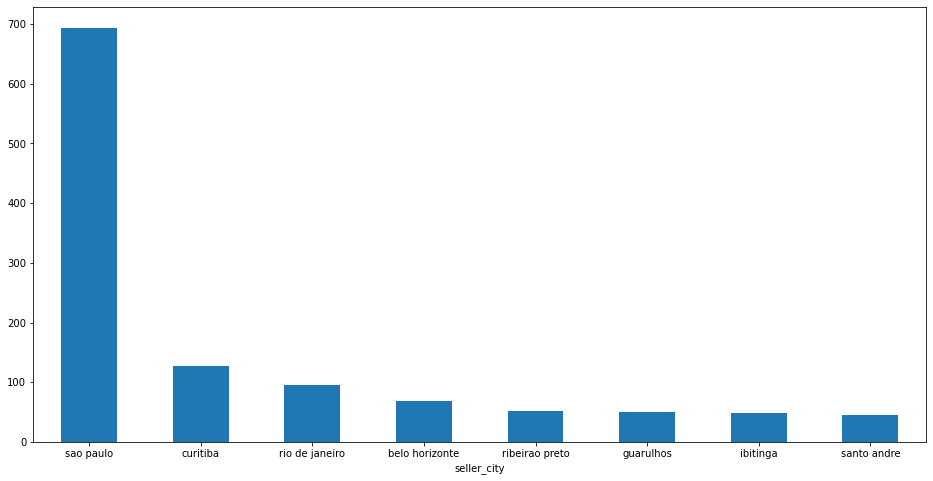

In [118]:
sellerstatus = sellers["seller_id"].nunique()
o1 = sellers.groupby('seller_city')['seller_id'].nunique().sort_values(ascending=False)
print("There are",sellerstatus,"unique sellers in the dataset.")
o2 = o1.head(8)
print(o2)

print("\nTop Seller by city covers", round(o2.sum()/orders.shape[0]*100,1),"percent of all the sellers.")
plt.figure(figsize=(16,8))
o2.plot(kind="bar",rot=0)

There are 3095 unique sellers in the dataset.
seller_state
SP    1849
PR     349
MG     244
SC     190
RJ     171
RS     129
GO      40
DF      30
Name: seller_id, dtype: int64

Top Sellers by state represents 3.0 percent of all the sellers.


<AxesSubplot:xlabel='seller_state'>

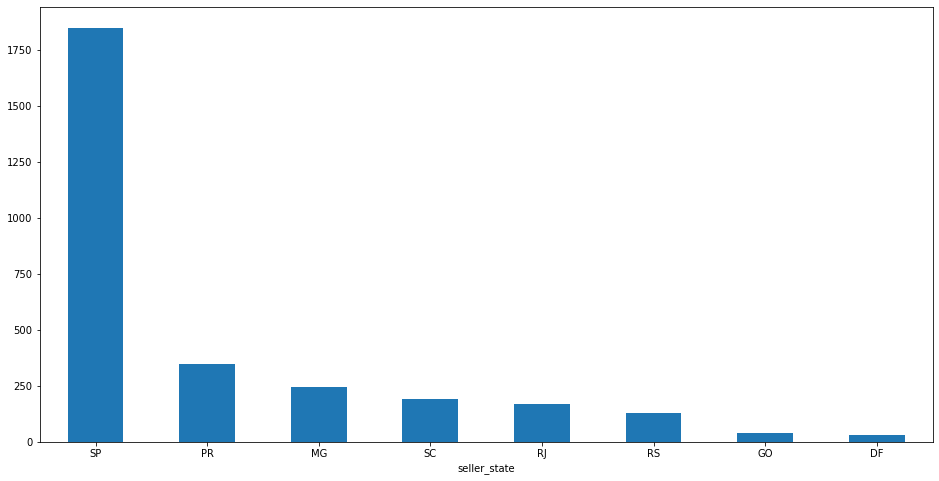

In [119]:
sellerstatus = sellers["seller_id"].nunique()
o1 = sellers.groupby('seller_state')['seller_id'].nunique().sort_values(ascending=False)
print("There are",sellerstatus,"unique sellers in the dataset.")
o2 = o1.head(8)
print(o2)

print("\nTop Sellers by state represents", round(o2.sum()/orders.shape[0]*100,1),"percent of all the sellers.")
plt.figure(figsize=(16,8))
o2.plot(kind="bar",rot=0)

## Products

In [120]:
products.info()
products.isnull().sum()
# need to fix missing data 610 is the same entry but missing description. 2 items also missing (1 competely missing all except ID
#other one is just missing weight, lenght, height, width) Dtypes changed from float64 to object as a result of replacing NA
products["product_category_name"].fillna("None", inplace = True)
products["product_name_lenght"].fillna("None", inplace = True)
products["product_description_lenght"].fillna("None", inplace = True)
products["product_photos_qty"].fillna("None", inplace = True)
products["product_weight_g"].fillna("0", inplace = True)
products["product_length_cm"].fillna("0", inplace = True)
products["product_height_cm"].fillna("0", inplace = True)
products["product_width_cm"].fillna("0", inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [121]:
products.isnull().sum()

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64

In [122]:
most_product=df.groupby('product_category_name_english').aggregate({'order_id':'count'}).rename(columns={'order_id':'order_count'}).sort_values(by='order_count',ascending=False).reset_index()
most_product.head()

,product_category_name_english,order_count
0,bed_bath_table,11990
1,health_beauty,10033
2,sports_leisure,9005
3,furniture_decor,8833
4,computers_accessories,8151


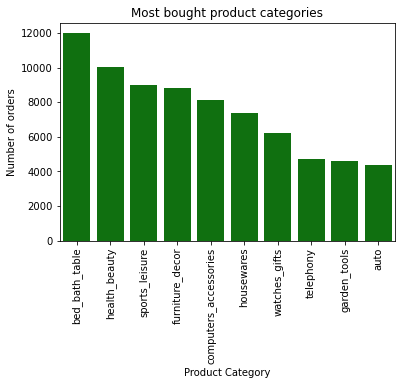

In [123]:
### Visualising top 10 most bought product categories:
sns.barplot(x='product_category_name_english',y='order_count',data=most_product[:10],color="green")
plt.xlabel("Product Category")
plt.ylabel("Number of orders")
plt.title("Most bought product categories")
plt.xticks(rotation='vertical')
plt.show()

There are 32951 unique products in the dataset.
product_category_name_english
bed_bath_table           3029
sports_leisure           2867
furniture_decor          2657
health_beauty            2444
housewares               2335
auto                     1900
computers_accessories    1639
toys                     1411
watches_gifts            1329
telephony                1134
Name: product_id, dtype: int64

Top 10 Products by category represent 20.9 percent of all the products.


<AxesSubplot:xlabel='product_category_name_english'>

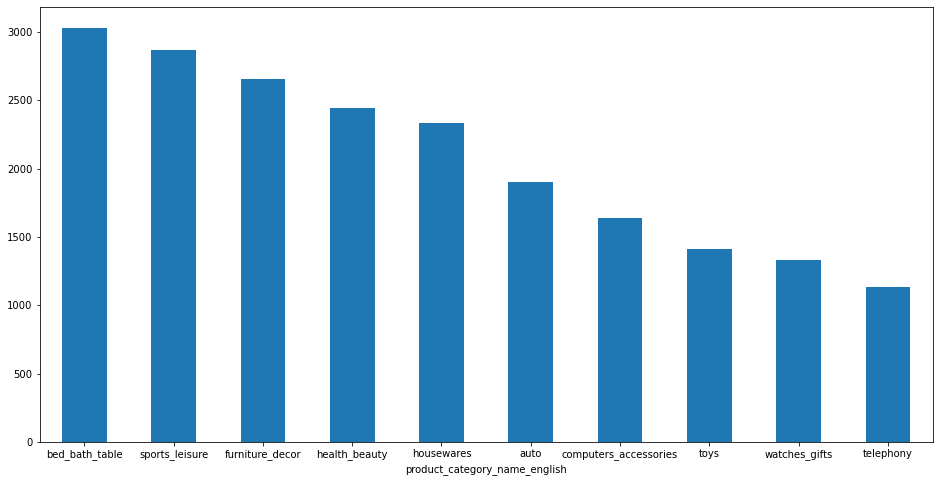

In [124]:
prodcat= df["product_id"].nunique()
o1 = df.groupby('product_category_name_english')['product_id'].nunique().sort_values(ascending=False)
print("There are",prodcat,"unique products in the dataset.")
o2 = o1.head(10)
print(o2)

print("\nTop 10 Products by category represent", round(o2.sum()/orders.shape[0]*100,1),"percent of all the products.")
plt.figure(figsize=(16,8))
o2.plot(kind="bar",rot=0)

## Payment

In [125]:
payments.info()
payments.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

## Categories

In [126]:
categories.info()
categories.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


product_category_name            0
product_category_name_english    0
dtype: int64

### NLP

In [127]:
reviews_low = reviews[reviews['review_score'] == 1]
reviews_low = reviews_low.dropna()
reviews_low['English'] = np.NaN

In [128]:
reviews_low

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,English
19,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37,NaN
167,5f938e5f5f2e9a75710b54feeb9ea610,d9ff0185a300435402f043124f530274,1,Médio,A peça não serviu,2018-05-11 00:00:00,2018-05-14 14:08:04,NaN
190,c40a6b6e0181e5ec0d12cbc2e12c49d3,f3468d6a2c7586711e9952242898aad4,1,falta de produto e quebra,Faltou 1 produto e os que recebi 1 veio quebrado,2018-05-23 00:00:00,2018-05-23 22:23:00,NaN
197,06f47dacd0575e592bf6a17e922ce6cd,82348f1b5f24ac795fa9320e02c49553,1,não recebi ainda,aqui está descrevendo como entregue só que ate...,2018-06-28 00:00:00,2018-06-29 16:34:46,NaN
277,f7eb8792e67d53e01a224bfa9b6802b2,a0f2f8b0523207a13f02225bc812ed23,1,Horrível,Cancelaram a minha compra um dia antes da entr...,2018-08-05 00:00:00,2018-08-05 09:27:55,NaN
...,...,...,...,...,...,...,...,...
99672,5d4beea8e2c71baee7f55c7ae3ae3313,4f11c536ca6b0a28ea1c7583d6a5df63,1,Insatisfeita,"A cadeira veio com defeito de fabrica, uma sol...",2018-06-15 00:00:00,2018-06-15 20:56:46,NaN
99702,623b07b8ac7a4947eb6a88f2a4def222,30a08f0074bc43c8284b61015a6c530d,1,não recomendo,meu produto veio estragado e ruim.,2018-06-13 00:00:00,2018-06-13 23:34:52,NaN
99729,44380245bf1a49875542ea0e7f216986,98efe48952662e6a45a1dc51770039d2,1,não recebi o produto aind,assim que receber produto eu avalio positivo,2018-06-26 00:00:00,2018-06-28 19:06:42,NaN
99829,5dcc936952f7e67f7faa64c8f57e97a9,719a2a4825d52ce82cbc8698a71495ba,1,produto não entregue,"o produto não foi entregue, a empresa não se p...",2018-05-24 00:00:00,2018-05-26 05:11:57,NaN


In [ ]:
from googletrans import Translator
import time

# translate reviews
translator = Translator()
translator.raise_Exception = True

#mini-batch loop. Loops 200 at a time. Hit failures with the translate API, switched to the slow iterrows loop below
#for i in range(0, len(reviews_low), 200): 
    #print(i)
    #a = reviews_low.iloc[i:i+199]
    #reviews_low['English']=a['review_comment_message'].apply(translator.translate, src='pt', dest='en').apply(getattr, args=('text',))

# row by row to handle when API limits are hit...not the best performance...can probably add the try/except to the mini-batch above for better performance, assuming it calls the google API in bulk
for i, row in reviews_low.iterrows():
    # Skip rows that were successful from previous attempts
    # Blank text also seems to throw an error in the translator
    if pd.isnull(row['English']) and not pd.isnull(row['review_comment_message']) and row['review_comment_message'].strip() != '':
        try:
            #getattr is to retrieve the object value for 'text', returns None if 'text' is not in the object
            print(row['review_comment_message'])
            print(translator.translate(row['review_comment_message'], src='pt', dest='en'))
            translator.translate(row['review_comment_message'], src='pt', dest='en')
            t = translator.translate(row['review_comment_message'], src='pt', dest='en')
            translation
            reviews_low.at[i, 'English'] = getattr(translation, 'text')
        # Most likely the 429 status code error from too many attempts
        except Exception as e:
            print('Error on {}: {}'.format(i, row['review_comment_message']))
            print(e)
            print('pausing for 1min...')
            time.sleep(60)
            print('trying again...')
            translation = translator.translate(row['review_comment_message'], src='pt', dest='en')
            print(translation)
            reviews_low.at[i, 'English'] = getattr(translation, 'text')
            print('Success! Moving on.')

In [ ]:
# save translated reviews
reviews_low.to_csv("reviews_low.csv")

In [129]:
#translated = pd.read_csv('reviews_low.csv')
translated = pd.read_csv('reviews_MASTERLOW.csv')

In [131]:
# pre process text
english = translated['English']
# replace numbers of words
english = english.apply(lambda t: re.sub(r"(\d+)", lambda x: num2words(int(x.group(0))), str(t)))
# replace special characters
english = english.apply(lambda t: re.sub(r"[^a-zA-Z0-9]+", ' ', str(t)))
# make all letters in a lower case
english = english.apply(lambda t: str(t).lower())

# tokenize text and remove stop words
tokenized_reviews = english.apply(lambda t: word_tokenize(str(t)))
tokenized_reviews = tokenized_reviews.apply(lambda t: remove_stop_words(t))

# spell check and stemming
tokenized_reviews = tokenized_reviews.apply(lambda t: spell_and_stem_words(t))

#tokenized_reviews.head(100)

reviews_text = tokenized_reviews.apply(lambda t: " ".join(t))


In [132]:
# feature matrix
# creating the feature matrix
matrix = CountVectorizer(max_features=10000, ngram_range=(2, 2))
X = matrix.fit_transform(reviews_text).toarray()
matrix.vocabulary_
#
pd.set_option('display.max_rows', None)
phrases = pd.DataFrame()
phrases['phrases'] = matrix.get_feature_names()
phrases['frequency'] = X.sum(axis=0)

phrases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   phrases    10000 non-null  object
 1   frequency  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [133]:
phrases.to_csv("phrases_eng_2_2.csv")

# RFM

In [134]:
# change datatime
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_delivered_carrier_date"] = pd.to_datetime(df["order_delivered_carrier_date"])
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])
df.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
payment_sequential                      float64
payment_type                             object
payment_installments                    float64
payment_value                           float64
review_id                                object
review_score                              int64
review_comment_title                     object
review_comment_message                   object
review_creation_date                    

In [135]:
# need to fix missing data 610 is the same entry but missing description. 2 items also missing (1 competely missing all except ID
#other one is just missing weight, lenght, height, width) Dtypes changed from float64 to object as a result of replacing NA
df["product_category_name"].fillna("None", inplace = True)
df["product_name_lenght"].fillna("None", inplace = True)
df["product_description_lenght"].fillna("None", inplace = True)
df["product_photos_qty"].fillna("None", inplace = True)
df["product_weight_g"].fillna("0", inplace = True)
df["product_length_cm"].fillna("0", inplace = True)
df["product_height_cm"].fillna("0", inplace = True)
df["product_width_cm"].fillna("0", inplace = True)

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119151 entries, 0 to 119150
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119151 non-null  object        
 1   customer_id                    119151 non-null  object        
 2   order_status                   119151 non-null  object        
 3   order_purchase_timestamp       119151 non-null  datetime64[ns]
 4   order_approved_at              118974 non-null  object        
 5   order_delivered_carrier_date   117065 non-null  datetime64[ns]
 6   order_delivered_customer_date  115730 non-null  datetime64[ns]
 7   order_estimated_delivery_date  119151 non-null  datetime64[ns]
 8   customer_unique_id             119151 non-null  object        
 9   customer_zip_code_prefix       119151 non-null  int64         
 10  customer_city                  119151 non-null  object        
 11  

In [137]:
# --Group data by customerID--
# Create TotalSum column for online dataset
#df['TotalSum'] = df['price'] * online['UnitPrice']
# Create snapshot date
snapshot_date = df['order_purchase_timestamp'].max() + datetime.timedelta(days=1)
print(snapshot_date)
# Grouping by CustomerID
data_process = df.groupby(['customer_id']).agg({
        'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
        'order_id': 'count',
        'price': 'sum'})
# Rename the columns
data_process.rename(columns={'order_purchase_timestamp': 'Recency',
                         'order_id': 'Frequency',
                         'price': 'MonetaryValue'}, inplace=True)

2018-10-18 17:30:18


In [138]:
# Print top 5 rows and shape of dataframe
print(data_process.head())
print('{:,} rows; {:,} columns'
      .format(data_process.shape[0], data_process.shape[1]))

                                  Recency  Frequency  MonetaryValue
customer_id                                                        
00012a2ce6f8dcda20d059ce98491703      338          1          89.80
000161a058600d5901f007fab4c27140      459          1          54.90
0001fd6190edaaf884bcaf3d49edf079      597          1         179.99
0002414f95344307404f0ace7a26f1d5      428          1         149.90
000379cdec625522490c315e70c7a9fb      199          1          93.00
99,441 rows; 3 columns


RFM Visualization

/Users/aleksandr/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/aleksandr/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/aleksandr/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

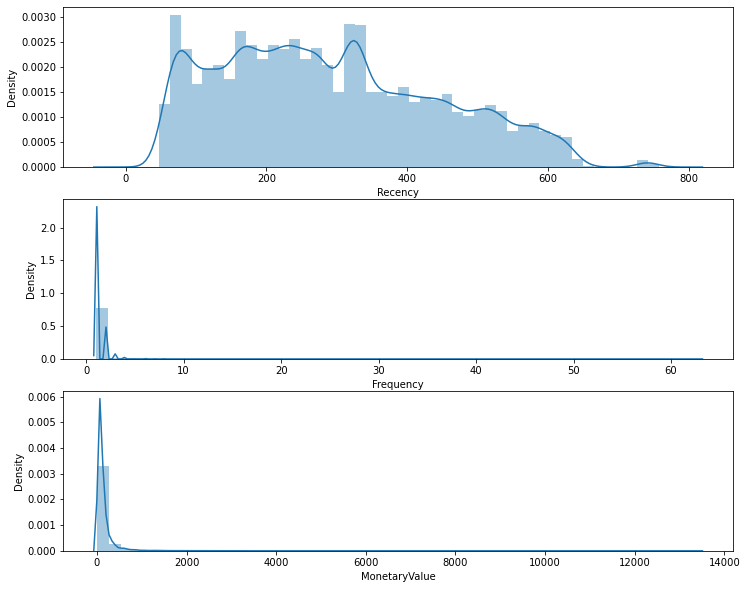

In [139]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(data_process['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(data_process['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(data_process['MonetaryValue'])
# Show the plot
plt.show()

In [140]:
c1 = data_process['Frequency'].unique()
print (c1)

[ 1  4  2  3  6  7  5  8 10 12 11 15 38  9 16 20 63 24 13 21 14 26 29 22
 19]


In [141]:
data_process.head()

,Recency,Frequency,MonetaryValue
customer_id,,,
00012a2ce6f8dcda20d059ce98491703,338,1,89.80
000161a058600d5901f007fab4c27140,459,1,54.90
0001fd6190edaaf884bcaf3d49edf079,597,1,179.99
0002414f95344307404f0ace7a26f1d5,428,1,149.90
000379cdec625522490c315e70c7a9fb,199,1,93.00


In [142]:
RFM_process = data_process

In [143]:
RFM_K3 = data_process.reset_index()
RFM_K3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customer_id    99441 non-null  object 
 1   Recency        99441 non-null  int64  
 2   Frequency      99441 non-null  int64  
 3   MonetaryValue  99441 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.0+ MB


Calculate R F M

In [144]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(data_process['Frequency'].rank(method='first'), q=4, labels=f_labels)
# Create new columns R and F 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values)
data_process.head()

,Recency,Frequency,MonetaryValue,R,F
customer_id,,,,,
00012a2ce6f8dcda20d059ce98491703,338,1,89.80,2,1
000161a058600d5901f007fab4c27140,459,1,54.90,1,1
0001fd6190edaaf884bcaf3d49edf079,597,1,179.99,1,1
0002414f95344307404f0ace7a26f1d5,428,1,149.90,1,1
000379cdec625522490c315e70c7a9fb,199,1,93.00,3,1


In [145]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(data_process['MonetaryValue'], q=4, labels=m_labels)
# Create new column M
data_process = data_process.assign(M = m_groups.values)

In [146]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
data_process['RFM_Segment_Concat'] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat
customer_id,,,,,,,
00012a2ce6f8dcda20d059ce98491703,338,1,89.80,2,1,3,2.01.03.0
000161a058600d5901f007fab4c27140,459,1,54.90,1,1,2,1.01.02.0
0001fd6190edaaf884bcaf3d49edf079,597,1,179.99,1,1,4,1.01.04.0
0002414f95344307404f0ace7a26f1d5,428,1,149.90,1,1,3,1.01.03.0
000379cdec625522490c315e70c7a9fb,199,1,93.00,3,1,3,3.01.03.0


In [147]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_count_unique.sum())

64


In [148]:
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

customer_id
00012a2ce6f8dcda20d059ce98491703    6
000161a058600d5901f007fab4c27140    4
0001fd6190edaaf884bcaf3d49edf079    6
0002414f95344307404f0ace7a26f1d5    5
000379cdec625522490c315e70c7a9fb    7
Name: RFM_Score, dtype: int64


In [149]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
customer_id,,,,,,,,,
00012a2ce6f8dcda20d059ce98491703,338,1,89.80,2,1,3,2.01.03.0,6,Potential
000161a058600d5901f007fab4c27140,459,1,54.90,1,1,2,1.01.02.0,4,Needs Attention
0001fd6190edaaf884bcaf3d49edf079,597,1,179.99,1,1,4,1.01.04.0,6,Potential
0002414f95344307404f0ace7a26f1d5,428,1,149.90,1,1,3,1.01.03.0,5,Promising
000379cdec625522490c315e70c7a9fb,199,1,93.00,3,1,3,3.01.03.0,7,Loyal


In [150]:
rfm_extract = rfm.reset_index()
rfm_extract.to_excel('RFM ranking result.xlsx', index = False)

In [151]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency MonetaryValue       
                      mean      mean          mean  count
RFM_Level                                                
Can't Loose Them     205.4       1.5         242.6  31822
Champions            262.2       1.1         141.5  17553
Loyal                301.0       1.1         109.2  17937
Needs Attention      446.3       1.0          39.2   5008
Potential            346.2       1.0          87.0  15611
Promising            396.1       1.0          52.4   9804
Require Activation   509.4       1.0          26.7   1706


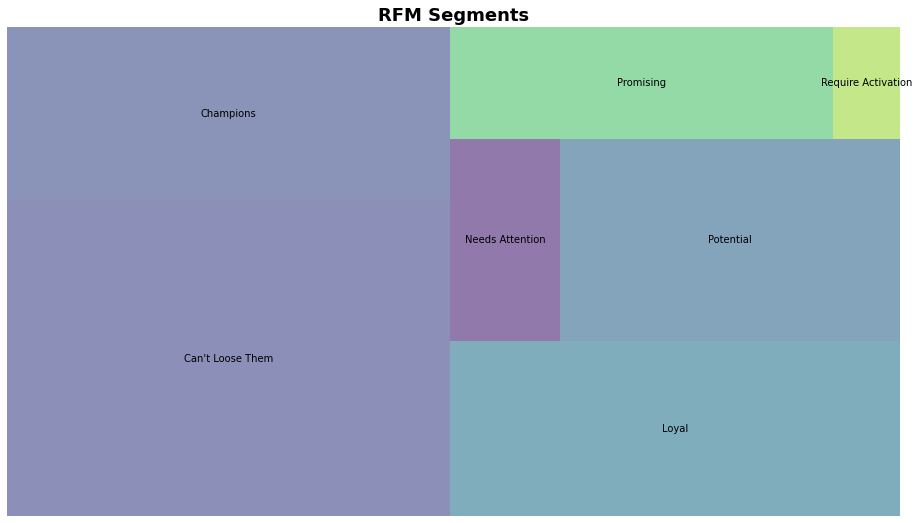

In [152]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

# K_mean

## Outlier Treatment

In [153]:
RFM_process = RFM_process.reset_index()

In [154]:
RFM_process.head()

,customer_id,Recency,Frequency,MonetaryValue
0,00012a2ce6f8dcda20d059ce98491703,338,1,89.80
1,000161a058600d5901f007fab4c27140,459,1,54.90
2,0001fd6190edaaf884bcaf3d49edf079,597,1,179.99
3,0002414f95344307404f0ace7a26f1d5,428,1,149.90
4,000379cdec625522490c315e70c7a9fb,199,1,93.00


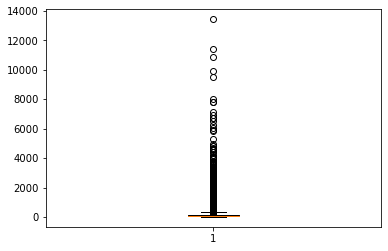

In [155]:
# outlier treatment for MonetaryValue
plt.boxplot(RFM_process.MonetaryValue)
Q1 = RFM_process.MonetaryValue.quantile(0.25)
Q3 = RFM_process.MonetaryValue.quantile(0.75)
IQR = Q3 - Q1
RFM_process = RFM_process[(RFM_process.MonetaryValue >= (Q1 - 1.5*IQR)) & (RFM_process.MonetaryValue <= (Q3 + 1.5*IQR))]

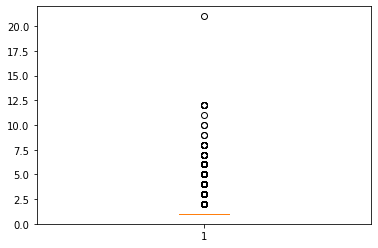

In [156]:
# outlier treatment for Frequency
plt.boxplot(RFM_process.Frequency)
Q1 = RFM_process.Frequency.quantile(0.25)
Q3 = RFM_process.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM_process = RFM_process[(RFM_process.Frequency >= (Q1 - 1.5*IQR)) & (RFM_process.Frequency <= (Q3 + 1.5*IQR))]

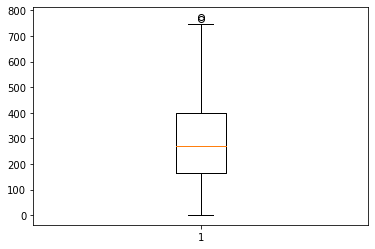

In [157]:
# outlier treatment for Recency
plt.boxplot(RFM_process.Recency)
Q1 = RFM_process.Recency.quantile(0.25)
Q3 = RFM_process.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM_process = RFM_process[(RFM_process.Recency >= (Q1 - 1.5*IQR)) & (RFM_process.Recency <= (Q3 + 1.5*IQR))]

In [158]:
RFM_process.head(20)

,customer_id,Recency,Frequency,MonetaryValue
0,00012a2ce6f8dcda20d059ce98491703,338,1,89.80
1,000161a058600d5901f007fab4c27140,459,1,54.90
2,0001fd6190edaaf884bcaf3d49edf079,597,1,179.99
3,0002414f95344307404f0ace7a26f1d5,428,1,149.90
4,000379cdec625522490c315e70c7a9fb,199,1,93.00
5,0004164d20a9e969af783496f3408652,554,1,59.99
6,000419c5494106c306a97b5635748086,229,1,34.30
7,00046a560d407e99b969756e0b10f282,304,1,120.90
8,00050bf6e01e69d5c0fd612f1bcfb69c,396,1,69.99
10,0005aefbb696d34b3424dccd0a0e9fd0,120,1,134.90


## Scaling the RFM data

In [159]:
# standardise all parameters
RFM_norm1 = RFM_process.drop(["customer_id"], axis=1)
#RFM_norm1.Recency = RFM_norm1.Recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

In [160]:
RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['Recency','Frequency','MonetaryValue']
RFM_norm1.head()

,Recency,Frequency,MonetaryValue
0,0.314978,0.0,-0.016438
1,1.103349,0.0,-0.549341
2,2.002483,0.0,1.360711
3,0.901369,0.0,0.901254
4,-0.590671,0.0,0.032424


In [161]:
# Kmeans with K=5
model_clus5 = KMeans(n_clusters = 5, max_iter=50)
model_clus5.fit(RFM_norm1)

KMeans(max_iter=50, n_clusters=5)

In [162]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])

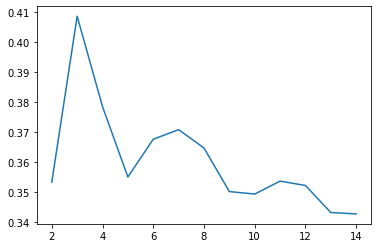

In [163]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])

In [164]:
RFM_norm1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80522 entries, 0 to 80521
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        80522 non-null  float64
 1   Frequency      80522 non-null  float64
 2   MonetaryValue  80522 non-null  float64
dtypes: float64(3)
memory usage: 1.8 MB


In [165]:
RFM_K3 = RFM_K3.drop(["customer_id"], axis=1)
kmeans_3 = KMeans(n_clusters=3).fit(RFM_K3)

In [166]:
RFM_K3['Cluster'] = kmeans_3.labels_
RFM_K3.head()

,Recency,Frequency,MonetaryValue,Cluster
0,338,1,89.80,1
1,459,1,54.90,1
2,597,1,179.99,1
3,428,1,149.90,1
4,199,1,93.00,0


In [167]:
RFM_K3.to_excel('RFM ranking result-RFMK3.xlsx', index = False)

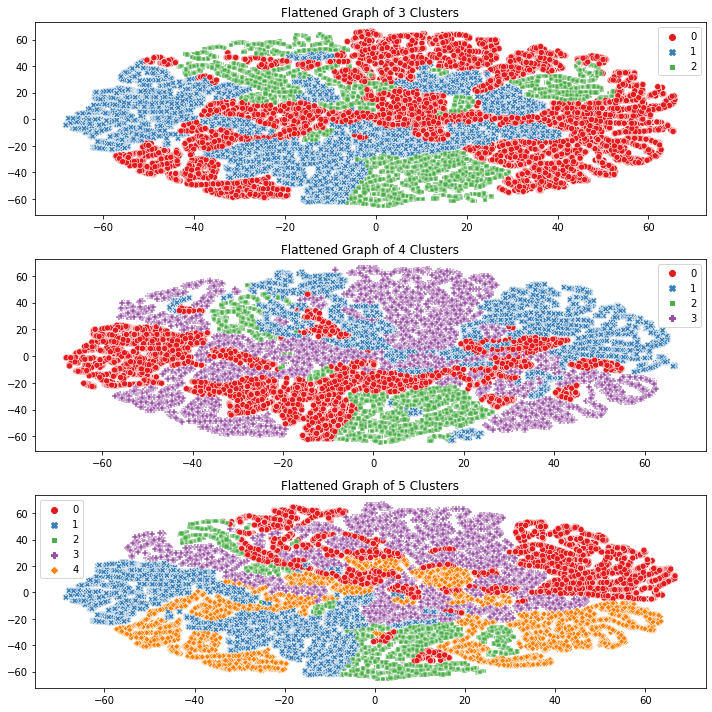

In [168]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)
# Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new.drop(["customer_id"], axis=1))
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_norm1, 3, RFM_process)
plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_norm1, 4, RFM_process)
plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_norm1, 5, RFM_process)
plt.tight_layout()